In [1]:
%cd /kaggle/input/flickr8k

/kaggle/input/flickr8k


In [2]:
import tensorflow as tf
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle as pkl
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import layers,Model

In [3]:
vgg16 = VGG16(weights='imagenet')
feature_extract = Model(inputs = vgg16.input, outputs = vgg16.layers[-2].output)

2023-01-21 05:02:23.438386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 05:02:23.531810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 05:02:23.532722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 05:02:23.534532: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

553476096/553467096 [==============================] - 4s 0us/step


In [4]:
feature = dict()
for img_name in tqdm(os.listdir('Images')):
    img = load_img('Images/'+ img_name, target_size=(224,224))
    img = img_to_array(img)
    img = img[None,:]
    img = preprocess_input(img)
    feature[img_name] = feature_extract.predict(img)

  0%|          | 0/8091 [00:00<?, ?it/s]2023-01-21 05:02:31.467795: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-21 05:02:32.501969: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 8091/8091 [08:35<00:00, 15.69it/s]


In [5]:
df = pd.read_csv('captions.txt')

In [6]:
%cd /kaggle/working

/kaggle/working


In [7]:
train_df, remain_df = train_test_split(df, 
                                        test_size=0.2,
                                        random_state=42)

val_df, test_df = train_test_split(remain_df, 
                                    test_size = 0.5,
                                    random_state=42)
train_df.reset_index(drop = True, inplace = True)
val_df.reset_index(drop = True, inplace = True)
test_df.reset_index(drop = True, inplace = True)

In [8]:
START_TOKEN = 'startseq'
END_TOKEN = 'endseq'
def preprocess_caption(s):
    s = START_TOKEN + ' ' + s + ' ' + END_TOKEN
    s = s.lower()
    s = re.sub(r'[^\w\s]','',s)
    s = re.sub(r'\s+',' ',s)
    return s
df.caption = df.caption.apply(preprocess_caption)

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.caption)
vocab_size = len(tokenizer.word_index) + 1
max_len = max(df.caption.str.split().agg(len))

In [10]:
with open('tokenizer.pkl', 'wb+') as f:
    pkl.dump(tokenizer,f)

In [11]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, df, feature, batch_size, tokenizer, max_len, vocab_size):
        self.df = df
        self.batch_size = batch_size
        self.feature = feature
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.n = len(self.df)
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        
        X1, X2, y = list(), list(), list()
        batch = self.df.iloc[start : end, :]
        image_names = batch['image'].to_list()
        for img_name in image_names:
            captions = batch.loc[batch.image == img_name, 'caption'].to_list()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen= self.max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes= self.vocab_size)[0]
                    X1.append(self.feature[img_name][0])
                    X2.append(in_seq)
                    y.append(out_seq)
        return (np.array(X1), np.array(X2)), np.array(y)
    
    def __len__(self):
        return self.n // self.batch_size

# Model

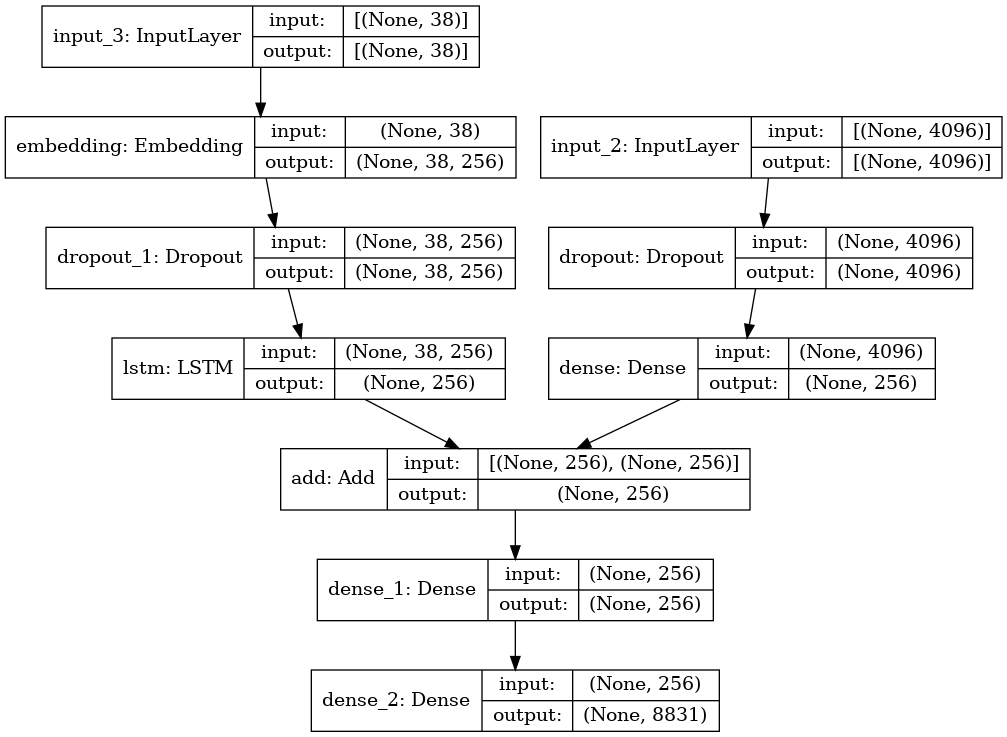

In [12]:
input1 = layers.Input(shape=(4096,))
fe1 = layers.Dropout(0.5)(input1)
fe2 = layers.Dense(256, activation= 'relu')(fe1)

input2 = layers.Input(shape=(max_len,))
enc1 = layers.Embedding(vocab_size,
                        256,
                        mask_zero=True
                        )(input2)
enc2 = layers.Dropout(0.5)(enc1)
enc3 = layers.LSTM(256)(enc2)

decoder1 = layers.add([fe2, enc3])
decoder2 = layers.Dense(256, activation = 'relu')(decoder1)
output = layers.Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [input1, input2],
                outputs = output)

model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam'
        )

plot_model(model, show_shapes = True)

In [13]:
BATCH_SIZE = 32
EPOCHS = 30
train_dataloader = Dataloader(df = train_df, 
                              feature = feature, 
                              batch_size = BATCH_SIZE,
                              tokenizer = tokenizer,
                              max_len = max_len,
                              vocab_size = vocab_size)
val_dataloader = Dataloader(df = val_df, 
                              feature = feature, 
                              batch_size = BATCH_SIZE,
                              tokenizer = tokenizer,
                              max_len = max_len,
                              vocab_size = vocab_size)
test_dataloader = Dataloader(df = test_df, 
                              feature = feature, 
                              batch_size = BATCH_SIZE,
                              tokenizer = tokenizer,
                              max_len = max_len,
                              vocab_size = vocab_size)

In [14]:
model_save = 'model.h5'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = model_save,
        mode = 'min',
        save_best_only=True,
        save_weights_only=True,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        min_delta=.0001
    )
]

In [15]:
history = model.fit(
        train_dataloader,
        epochs = EPOCHS,
        validation_data = val_dataloader,
        callbacks = callbacks,
        )

Epoch 1/30
1011/1011 [==============================] - 160s 154ms/step - loss: 4.4625 - val_loss: 3.8158
Epoch 2/30
1011/1011 [==============================] - 156s 154ms/step - loss: 3.4882 - val_loss: 3.5277
Epoch 3/30
1011/1011 [==============================] - 155s 153ms/step - loss: 3.1443 - val_loss: 3.4298
Epoch 4/30
1011/1011 [==============================] - 155s 153ms/step - loss: 2.9203 - val_loss: 3.4093
Epoch 5/30
1011/1011 [==============================] - 154s 153ms/step - loss: 2.7572 - val_loss: 3.4186
Epoch 6/30
1011/1011 [==============================] - 154s 153ms/step - loss: 2.6233 - val_loss: 3.4650
Epoch 7/30
1011/1011 [==============================] - 154s 152ms/step - loss: 2.5165 - val_loss: 3.5230
Epoch 8/30
1011/1011 [==============================] - 155s 153ms/step - loss: 2.4299 - val_loss: 3.5607
Epoch 9/30
1011/1011 [==============================] - 156s 154ms/step - loss: 2.3592 - val_loss: 3.6130
Epoch 00009: early stopping


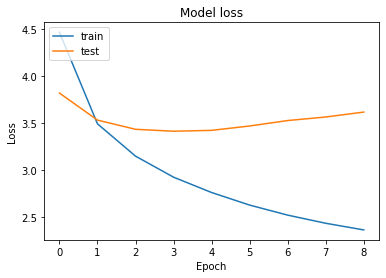

In [16]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc = "upper left")
plt.show()

In [17]:
result = model.evaluate(test_dataloader)
print(f"Test loss, test accuracy: {result}")

126/126 [==============================] - 5s 41ms/step - loss: 3.5667
Test loss, test accuracy: 3.5667052268981934


In [18]:
def predict(image_name, feature_extract, model, tokenizer, max_len, start_token = 'startseq', end_token = 'endseq'):
    output = start_token
    img = load_img(image_name, target_size=(224,224))
    img = img_to_array(img)
    img = img[None,:]
    img = preprocess_input(img)
    img_feature = feature_extract.predict(img)
    for i in range(max_len):
        sequence = tokenizer.texts_to_sequences([output])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([img_feature, sequence])
        idx = np.argmax(yhat)
        if idx in tokenizer.index_word:
            token = tokenizer.index_word[idx]
            output += ' ' + token
            if token == end_token:
                break
        else:
            break
    return output

In [19]:
%cd /kaggle/input/flickr8k

/kaggle/input/flickr8k


In [20]:
image_name = '1045521051_108ebc19be.jpg'
print('Real: ',test_df.loc[test_df.image == image_name,:].caption.tolist())
predict('Images/'+image_name, feature_extract, model, tokenizer, max_len)

Real:  []


'startseq playing with a toy in a living room with a television in the background of them also also also also also also also also also also holding a toy in his hand with a television in his hand'

In [21]:
image_name = '1009434119_febe49276a.jpg'
print('Real: ',test_df.loc[test_df.image == image_name,:].caption.tolist())
predict('Images/'+image_name, feature_extract, model, tokenizer, max_len)

Real:  []


'startseq dog running through grass with a dog in the background watching them is running in the grass with a dog in his mouth and a dog follows him on it is running in the grass with a large'